# Project 2 : Single Agent Continuous Control for the Reacher Task

---

Author : Rohan Sarkar

## 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


Load the necessary libraries and software modules 

In [2]:
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import copy
from collections import namedtuple, deque
from unityagents import UnityEnvironment

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [3]:
# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


## 3. Take Random Actions in the Environment 
[For testing if environment has been set up properly]

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.13999999687075615


## 4. Solve the Reacher Task using DDPG Algorithm

The DDPG Algorithm is an actor-critic, model-free, off-policy algorithm based on the deterministic policy gradient that can operate over continuous action spaces proposed in the paper Lillicrap et al, 2015. The main highlights of the algorithm are as follows: 
- It uses two neural networks -- an actor that learns a policy function from the state and a critic that learns a value function from state-action pairs. This is implemented in Section 4.2.
- The algorithm uses experience replay to store experiences of the agent interacting with the environment and subsequently sampling mini-batches of uncorrelated experiences for training. This is implemented in Section 4.3

The agent is implemented in Section 4.4 and the code for training the agent is in Section 4.5. Some important implementational details are as follows: 
- To boost exploration, Ornstein-Uhlenbeck Process is used to add noise to the action output. The goal is to generate temporally correlated exploration for exploration efficiency in physical control problems with inertia. 
- To stablize the training, soft update is used to update model weights of the **target** actor-critic network from the **local** actor-critic network. 



### 4.1 Set the hyper-parameters

In [7]:
"""
Hyper-parameters for Replay memory and generation of mini-batches of experiences
"""
BUFFER_SIZE = int(1e6) # replay buffer size
BATCH_SIZE = 128       # minibatch size
"""
Hyper-parameters for DDPG Training
"""
N_EPISODES = 2000      # maximum number of training episodes
N_MAX_TIMESTEPS = 1000 # maximum number of timesteps per episode
N_STATE = state_size   # state size for DDPG Agent
N_ACTION = action_size # action size for DDPG Agent
SEED = 1               # random seed
GAMMA = 0.99           # discount factor
TAU = 1e-3             # for soft update of target parameters
WEIGHT_DECAY = 0       # L2 weight decay
LEARN_EVERY = 20       # learning timestep interval
LEARN_NUM = 10         # number of learning passes
GRAD_CLIPPING = 1.0    # gradient clipping 
# Ornstein-Uhlenbeck noise parameters
OU_MEAN = 0.0
OU_SIGMA = 0.2
OU_THETA = 0.15
EPSILON = 1.0         
EPSILON_DECAY = 1e-6
"""
Hyper-parameters for Actor and Critic
"""
LR_ACTOR = 1e-3        # learning rate of the actor
LR_CRITIC = 1e-3       # learning rate of the critic
ACTOR_NN = [400, 200]  # hidden layer sizes of the actor network
CRITIC_NN = [400, 200] # hidden layer sizes of the critic network
WEIGHT_INIT = 3e-3     # initialize weights 
# Select GPU for training if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 4.2 Define the Actor and Critic Network Architecture
- The **Actor Network** learns the policy function and maps states to actions. It consists of three fully connected layers with batch normalization at the first layer. It uses ReLU activation function for the first two layers and uses tanh in the last layer to ensure that the continuous action values range between [-1, 1].
- The **Critic Network** learns the value function and maps (state,action) pairs to Q-values. It also consists of three fully connected layers with batch normalization applied at the first layer. It uses ReLU activation function in all the layers except the last one. The last layer has no activation function so that we get the actual Q-values.

In [8]:
"""
=========================================================================
                    Actor Model - Learns Policy Function
=========================================================================

Parameters:
-----------
state_size (int): Dimension of each state
action_size (int): Dimension of each action
seed (int) : Random seed
NN (list) : Number of nodes in the hidden layers        
"""
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, NN=ACTOR_NN):
        """
        Initialize parameters and build model.
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, NN[0])
        self.bn1 = nn.BatchNorm1d(NN[0])
        self.fc2 = nn.Linear(NN[0], NN[1])
        self.fc3 =  nn.Linear(NN[1], action_size)
        self.reset_parameters()
        
    def initialize(self, layer):
        fan_in = layer.weight.data.size()[0]
        lim = 1. / np.sqrt(fan_in)
        return(-lim, lim)
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*self.initialize(self.fc1))
        self.fc2.weight.data.uniform_(*self.initialize(self.fc2))
        self.fc3.weight.data.uniform_(-1*WEIGHT_INIT, WEIGHT_INIT)
        
    def forward(self, state):
        """
        Build an actor(policy) network that maps states to actions
        tanh activation ensures that the action values range from [-1, 1]
        """
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))
"""
=========================================================================
                Critic Model - Learns Value Function
=========================================================================
Parameters:
-----------
state_size (int): Dimension of each state
action_size (int): Dimension of each action
seed (int) : Random seed
NN (list) : Number of nodes in the hidden layers
"""  
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, NN=CRITIC_NN):
        """
        Initialize parameters and build model.
        
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, NN[0])
        self.bn1 = nn.BatchNorm1d(NN[0])
        self.fc2 = nn.Linear(NN[0]+action_size, NN[1])
        self.fc3 = nn.Linear(NN[1], 1)
        self.reset_parameters()
        
    def initialize(self, layer):
        fan_in = layer.weight.data.size()[0]
        lim = 1. / np.sqrt(fan_in)
        return(-lim, lim)
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*self.initialize(self.fc1))
        self.fc2.weight.data.uniform_(*self.initialize(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        """
        Build a critic (value) network that maps (state,action) pairs to Q-values
        """
        x = F.relu(self.bn1(self.fc1(state)))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 4.3 Define the Replay Memory 
- For storing experience tuples
- For generating mini-batches of experiences for training

In [9]:
"""
=========================================================================
            Replay Memory to store and sample experiences
=========================================================================
Parameters:
-----------
buffer_size (int): maximum size of buffer
batch_size (int): size of each training batch
"""  
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object."""
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size) # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names = ["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """Store new experience to replay memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory for training"""
        experiences =  random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """"Return the current size of internal memory"""
        return len(self.memory)

### 4.4 Define and Instantiate the DDPG Agent

In [13]:
""" 
=========================================================================
            Ornsten-Uhlenbeck process to add exploration noise
=========================================================================
"""                  
class ExplorationNoise:
    def __init__(self, size, seed, mu=OU_MEAN, theta=OU_THETA, sigma=OU_SIGMA):
        """Initialize noise parameters"""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()
        
    def reset(self):
        """Reset the internal state to mean."""
        self.state = copy.copy(self.mu)
        
    def sample(self):
        """Update internal state and return it as a noise sample"""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state
"""
=========================================================================
    DDPG Agent that interacts with and learns from the environment
=========================================================================
Parameters:
-----------
state_size (int): dimension of each state
action_size (int): dimension of each action
random_seed (int): random seed
"""  
class Agent():   
    def __init__(self, state_size, action_size, random_seed=0):
        """Initialize an Agent object."""
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = EPSILON
        
        # Initialize the local and target Actor network
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        # Initialize the local and target Critic network
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # Initialize the Ornsten-Uhlenbeck process to add exploration noise
        self.noise = ExplorationNoise(action_size, random_seed)
        
        # Initialize the Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def reset(self):
        self.noise.reset()
        
    def step(self, state, action, reward, next_state, done, timestep):
        """ Save experience in replay memory, and use random sample from buffer to learn """
        self.memory.add(state, action, reward, next_state, done)
        
        """ Learn, when enough samples are available in memory """
        if len(self.memory) > BATCH_SIZE and timestep % LEARN_EVERY == 0:
            for _ in range(LEARN_NUM):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
    def act(self, state, add_noise=True):
        """ Returns actions for given state as per current policy """
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            action += self.epsilon * self.noise.sample()
            
        return np.clip(action, -1, 1)
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target_model = tau*θ_local_model + (1 - tau)*θ_target_model
        
        where, 
            θ_local_model: PyTorch model from which weights will be copied
            θ_target_model: PyToch model to which weights will be copied
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where,
            actor_target(state) -> action
            critic_target(state, action) -> Q-value 
            gamma (float): discount factor
        """
        """ 
        -----------------------------------------------------------------------------------
                                    Unpack mini-batch of experiences
                    experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done)
        -----------------------------------------------------------------------------------
        """
        states, actions, rewards, next_states, dones = experiences
        
        """ 
        -----------------------------------------------------------------------------------
                                Train Critic by minimizing the loss
        -----------------------------------------------------------------------------------
        """
        # get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # minimize the critic loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # gradient clipping for critic
        if GRAD_CLIPPING > 0:
            torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), GRAD_CLIPPING)
        self.critic_optimizer.step()
        
        """ 
        -----------------------------------------------------------------------------------
                            Train Actor using the sampled policy gradient
        -----------------------------------------------------------------------------------
        """
        # compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        """ 
        -----------------------------------------------------------------------------------
                                Update Actor-Critic Target Networks
        -----------------------------------------------------------------------------------
        """
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        # update epsilon decay
        if EPSILON_DECAY > 0:
            self.epsilon -= EPSILON_DECAY
            self.noise.reset()
"""
-----------------------------------------------------------------------------------
                        Instantiate the DDPG Agent
-----------------------------------------------------------------------------------
"""
agent = Agent(state_size=N_STATE, action_size=N_ACTION, random_seed=SEED)

### 4.5 Train the DDPG algorithm

In [14]:
"""
=========================================================================
                        Train the DDPG Algorithm
=========================================================================
Parameters:
-----------
num_episodes (int): maximum number of episodes for training
max_t (int)       : maximum number of time-steps per episode
actor_weights_name, critic_weights_name : actor and critic model names
"""  
def train(actor_weights_name, critic_weights_name, num_episodes=N_EPISODES, max_t=N_MAX_TIMESTEPS):
    """ 
    -----------------------------------------------------------------------------------
    Initialize data-structures to keep track of average-episode scores and moving average
    -----------------------------------------------------------------------------------
    """ 
    mean_scores = [] # list of mean scores from each episode
    moving_avgs = [] # list of moving averages
    best_score = -np.inf
    scores_window = deque(maxlen=100) # mean score from last 100 episodes based on Udacity Project requirements
    """ 
    -----------------------------------------------------------------------------------
    Start learning
    -----------------------------------------------------------------------------------
    """ 
    for i_episode in range(1, num_episodes + 1):
        """ Reset environment and agent at the beginning of each episode """
        env_info = env.reset(train_mode=True)[brain_name] # reset environment, with training mode ON
        scores = np.zeros(num_agents) # initialize score for each agent
        states = env_info.vector_observations # get current state 
        agent.reset() # reset agent
        start_time = time.time()
        """ Start episode """
        for t in range(max_t):
            """ Agent interacts with environment """
            actions = agent.act(states, add_noise=True) # determine optimal actions
            env_info = env.step(actions)[brain_name]  # apply actions to environment and get environment info
            next_states = env_info.vector_observations # extract next state information for each agent
            rewards = env_info.rewards # extract rewards received for the action taken by each agent
            dones = env_info.local_done # Determine terminal state or not
            """ Agent learns from uncorrelated experiences """
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        duration = time.time() - start_time
        """ 
        -----------------------------------------------------------------------------------
        Record score stats and print information
        -----------------------------------------------------------------------------------
        """ 
        mean_scores.append(np.mean(scores)) # save mean score for each episode
        scores_window.append(mean_scores[-1]) # save mean score to window
        moving_avgs.append(np.mean(scores_window)) # save moving average
        
        if i_episode % 50 == 0:
            print("\rEpisode {} ({}s)\tMean: {:.1f}\tMoving Avg: {:.1f}"\
                  .format(i_episode, round(duration), mean_scores[-1], moving_avgs[-1]))
        """ 
        -----------------------------------------------------------------------------------
        Save model weights when the task is solved (moving average score >= 30.0)
        -----------------------------------------------------------------------------------
        """ 
        if moving_avgs[-1] >= 30.0:
            print("\nEnvironment solved in {:d} episodes.\tAverage score: {:.2f}"\
                 .format(i_episode, moving_avgs[-1]))
            torch.save(agent.actor_local.state_dict(), actor_weights_name)
            torch.save(agent.critic_local.state_dict(), critic_weights_name)
            break        
    return mean_scores, moving_avgs
""" 
-----------------------------------------------------------------------------------
Train and save final model weights
-----------------------------------------------------------------------------------
""" 
scores, avgs = train('DDPG_actor_single.pth', 'DDPG_critic_single.pth')

Episode 50 (8s)	Mean: 3.3	Moving Avg: 1.5
Episode 100 (9s)	Mean: 5.1	Moving Avg: 2.4
Episode 150 (8s)	Mean: 5.7	Moving Avg: 4.0
Episode 200 (9s)	Mean: 9.6	Moving Avg: 5.4
Episode 250 (9s)	Mean: 9.2	Moving Avg: 7.3
Episode 300 (9s)	Mean: 6.7	Moving Avg: 8.7
Episode 350 (9s)	Mean: 8.4	Moving Avg: 9.7
Episode 400 (10s)	Mean: 10.6	Moving Avg: 10.7
Episode 450 (10s)	Mean: 18.6	Moving Avg: 11.4
Episode 500 (10s)	Mean: 11.8	Moving Avg: 12.6
Episode 550 (10s)	Mean: 13.2	Moving Avg: 14.0
Episode 600 (11s)	Mean: 15.7	Moving Avg: 15.1
Episode 650 (11s)	Mean: 15.4	Moving Avg: 15.3
Episode 700 (11s)	Mean: 16.9	Moving Avg: 16.1
Episode 750 (12s)	Mean: 15.5	Moving Avg: 18.1
Episode 800 (12s)	Mean: 26.3	Moving Avg: 18.8
Episode 850 (12s)	Mean: 26.2	Moving Avg: 19.5
Episode 900 (13s)	Mean: 28.7	Moving Avg: 21.0
Episode 950 (13s)	Mean: 23.5	Moving Avg: 22.8
Episode 1000 (13s)	Mean: 29.8	Moving Avg: 24.4
Episode 1050 (13s)	Mean: 29.4	Moving Avg: 26.2
Episode 1100 (13s)	Mean: 39.1	Moving Avg: 28.7

Enviro

## 5. Results and Plot of Rewards
As indicated above the enviroment was solved in 1121 episodes. 

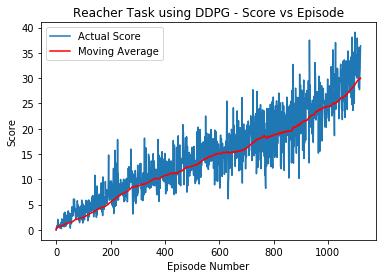

In [15]:
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores, label='Actual Score ')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode Number')
plt.title('Reacher Task using DDPG - Score vs Episode')
plt.legend(loc='upper left')
plt.show()

In [16]:
env.close()

## 6. Ideas for Future Work
- Would like to look into ways to speed up training. 
- Parallelize implementation with multiple agents interacting with the environment independently. More specifically, I would like to explore distributed policy gradient algorithms such as A3C, D4PG. 
- Replace the Replay Memory with Proritized Experience Replay for better performance. 